# **📦 Imports**
We start by importing all the essential Python libraries for our workflow — from **PyTorch** for deep learning to **Matplotlib & Seaborn** for visualizations, and **PIL** for image handling.


In [ ]:
# ==========================================
# 📦 Imports
# ==========================================
import os, time, random, math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **🔁 Reproducibility & Device Setup**
To ensure consistent results every time we run the code, we set a random seed for **Python, NumPy, and PyTorch**.  
We also detect if a GPU is available for faster training — otherwise, fallback to CPU.


In [ ]:
# ==========================================
# 🔁 Reproducibility & Device
# ==========================================
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# **⚙️ Configuration**
Here we define important configuration parameters such as:
- **Dataset location**  
- **Image size** (for resizing)  
- **Batch size** & **Number of workers**  
- **Learning rate** and **Epochs**  
- **Train/Validation/Test split ratios**  


In [ ]:
# ==========================================
# ⚙️ Config
# ==========================================
DATASET_DIR = "/content/drive/MyDrive/CNN Chest Xray"
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2
EPOCHS = 10
LR = 1e-3

# split ratios
TRAIN_R, VAL_R, TEST_R = 0.70, 0.15, 0.15
assert abs((TRAIN_R + VAL_R + TEST_R) - 1.0) < 1e-6


# **🧼 Data Transformations**
We apply transformations to prepare the dataset for training:
- Resize images to a fixed resolution
- Convert to tensors
- Normalize using ImageNet mean & standard deviation  

We also define an *unnormalize* function to convert normalized images back to a human-viewable format.


In [ ]:
# ==========================================
# 🧼 Transforms
# ==========================================
base_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# For visualizing images we need an "unnormalize"
inv_mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
inv_std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)

def unnormalize(t):
    return torch.clamp(t * inv_std + inv_mean, 0, 1)


# **📂 Load Full Dataset**
We load the dataset from the given directory using **`torchvision.datasets.ImageFolder`**, which automatically detects class subfolders and labels them.  
We then display:
- Class names
- Total image count
- Per-class image counts


In [ ]:
# ==========================================
# 📂 Load full dataset (single folder with class subfolders)
# ==========================================
full_ds = datasets.ImageFolder(DATASET_DIR, transform=base_transform)
class_names = full_ds.classes
num_classes = len(class_names)
targets = np.array([y for _, y in full_ds.samples])  # labels from ImageFolder
print("Classes:", class_names)
print("Total images:", len(full_ds))


Classes: ['Covid', 'Normal', 'Viral Pneumonia']
Total images: 4035


In [ ]:
# ==========================================
# 🔢 Overall per-class counts
# ==========================================
from collections import Counter
overall_counts = Counter(targets.tolist())
for idx, name in enumerate(class_names):
    print(f"{name:>12}: {overall_counts.get(idx,0)}")


       Covid: 1345
      Normal: 1345
Viral Pneumonia: 1345


# **✂️ Stratified Train/Val/Test Split**
To avoid class imbalance issues, we split the dataset **stratified by class labels** into:
- 70% Training
- 15% Validation
- 15% Testing  

We then create `Subset` objects for each split.


In [ ]:
# ==========================================
# ✂️ Stratified split indices (70/15/15)
# ==========================================
def stratified_split_indices(labels, train_r, val_r, test_r, seed=SEED):
    rng = np.random.default_rng(seed)
    labels = np.array(labels)
    cls_indices = {c: np.where(labels==c)[0].tolist() for c in np.unique(labels)}
    train_idx, val_idx, test_idx = [], [], []
    for c, idxs in cls_indices.items():
        rng.shuffle(idxs)
        n = len(idxs)
        n_train = int(round(train_r * n))
        n_val   = int(round(val_r * n))
        n_test  = n - n_train - n_val
        train_idx += idxs[:n_train]
        val_idx   += idxs[n_train:n_train+n_val]
        test_idx  += idxs[n_train+n_val:]
    # shuffle each split for good measure
    rng.shuffle(train_idx); rng.shuffle(val_idx); rng.shuffle(test_idx)
    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = stratified_split_indices(targets, TRAIN_R, VAL_R, TEST_R)

train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(full_ds, val_idx)
test_ds  = Subset(full_ds, test_idx)

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")


Train/Val/Test sizes: 2823/606/606


# **📊 Per-Class Counts per Split**
We verify that our splits preserve the **class balance** by counting the number of images for each class in each split.


In [ ]:
# ==========================================
# 📊 Per-class counts per split
# ==========================================
def split_counts(indices, labels, class_names):
    c = Counter(labels[indices])
    return {class_names[k]: c.get(k,0) for k in range(len(class_names))}

train_counts = split_counts(train_idx, targets, class_names)
val_counts   = split_counts(val_idx, targets, class_names)
test_counts  = split_counts(test_idx, targets, class_names)

print("Train per-class:", train_counts)
print("Val per-class  :", val_counts)
print("Test per-class :", test_counts)


Train per-class: {'Covid': 941, 'Normal': 941, 'Viral Pneumonia': 941}
Val per-class  : {'Covid': 202, 'Normal': 202, 'Viral Pneumonia': 202}
Test per-class : {'Covid': 202, 'Normal': 202, 'Viral Pneumonia': 202}


# **🚚 Data Loaders**
We create **PyTorch DataLoaders** for each split to efficiently:
- Batch the data
- Shuffle training samples
- Preload data using multiple workers


In [ ]:
# ==========================================
# 🚚 DataLoaders
# ==========================================
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


# **👀 Visualize One Image per Class**
Before training, we visualize one example from each class **after preprocessing** (resize & normalization) to confirm that the transformations are applied correctly.


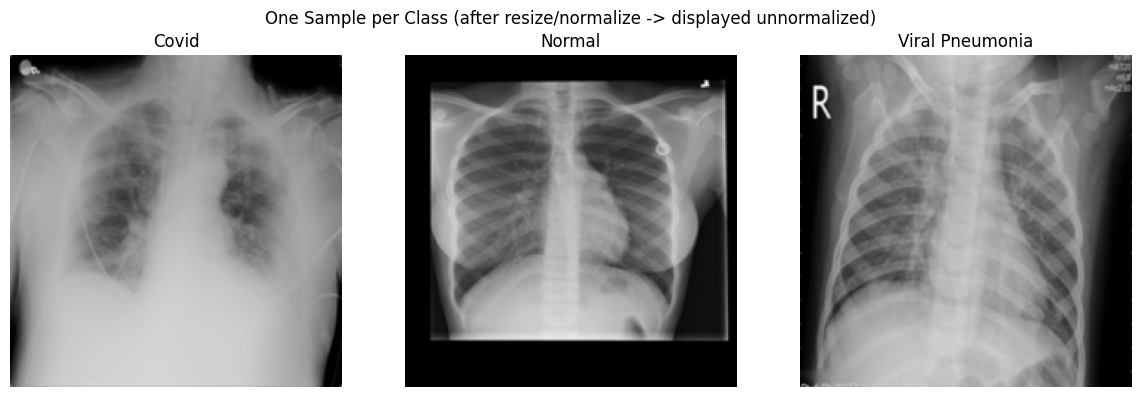

In [ ]:
# ==========================================
# 👀 Visualize one image per class (from full dataset)
# ==========================================
fig, axs = plt.subplots(1, num_classes, figsize=(4*num_classes, 4))
shown = set()
i = 0
for idx in range(len(full_ds)):
    _, label = full_ds.samples[idx]
    if label not in shown:
        img, _ = full_ds[idx]  # transformed (normalized)
        axs[i].imshow(unnormalize(img).permute(1,2,0))
        axs[i].set_title(class_names[label])
        axs[i].axis('off')
        shown.add(label)
        i += 1
        if i == num_classes:
            break
plt.suptitle("One Sample per Class (after resize/normalize -> displayed unnormalized)")
plt.tight_layout()
plt.show()


# **🧠 EfficientNet-B0 Architecture for 3-Class Classification**

We load **EfficientNet-B0** with pretrained ImageNet weights, replace its classifier to predict **3 classes** (Normal, Pneumonia, COVID), and move the model to the available device (CPU/GPU).



In [ ]:
# ==========================================
# 🧠 EfficientNet Model for 3-class classification
# ==========================================
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load EfficientNet-B0 with pretrained weights
efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Replace the classifier for 3 classes
num_features = efficientnet.classifier[1].in_features
efficientnet.classifier[1] = nn.Linear(num_features, 3)  # 3 classes: Normal, Pneumonia, COVID

# Move model to device
efficientnet = efficientnet.to(device)

# Print model summary
print(efficientnet)


Using device: cuda


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 129MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

# **⚡ Loss & Optimizer Setup**

We use **CrossEntropyLoss** for multi-class classification and the **Adam** optimizer with a learning rate of `1e-4` to train all EfficientNet parameters.


In [ ]:
# ==========================================
# ⚡ Loss, Optimizer, Helpers
# ==========================================

import torch.optim as optim
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(efficientnet.parameters(), lr=1e-4)


# **🏋️ Training & Validation Loop**

This function trains EfficientNet for the given epochs, tracking:

- **Training loss**  
- **Validation loss & accuracy**  
- **Total training time**  
- **Peak GPU memory usage**  

It returns a history dictionary for later visualization.


In [ ]:
# ==========================================
# ⏱️ Training + Validation Loop for EfficientNet
# ==========================================
def train_efficientnet(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    """
    Train and validate EfficientNet model.
    Logs training/validation loss, validation accuracy,
    total training time, and peak GPU memory.
    """
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    # Reset peak GPU memory stats
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        # --- Training Loop ---
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)

        # --- Validation Loop ---
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total

        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}")

    total_time = time.time() - start_time
    peak_mem_mb = torch.cuda.max_memory_allocated(device) / (1024**2) if torch.cuda.is_available() else 0

    print(f"\n⏳ Total Training Time: {total_time:.2f}s | 💾 Peak GPU Memory: {peak_mem_mb:.2f} MB")
    return history


# **🚀 Model Training**
We train the model for the defined number of epochs and log the performance for each epoch.


In [ ]:
# Train EfficientNet
history = train_efficientnet(
    model=efficientnet,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=10
)


Epoch 1/10 | Train Loss: 0.1121 | Val Loss: 0.0822 | Val Acc: 0.9769
Epoch 2/10 | Train Loss: 0.0610 | Val Loss: 0.0796 | Val Acc: 0.9752
Epoch 3/10 | Train Loss: 0.0379 | Val Loss: 0.0726 | Val Acc: 0.9802
Epoch 4/10 | Train Loss: 0.0337 | Val Loss: 0.0802 | Val Acc: 0.9818
Epoch 5/10 | Train Loss: 0.0307 | Val Loss: 0.0765 | Val Acc: 0.9835
Epoch 6/10 | Train Loss: 0.0143 | Val Loss: 0.0581 | Val Acc: 0.9818
Epoch 7/10 | Train Loss: 0.0156 | Val Loss: 0.0873 | Val Acc: 0.9802
Epoch 8/10 | Train Loss: 0.0133 | Val Loss: 0.0861 | Val Acc: 0.9835
Epoch 9/10 | Train Loss: 0.0180 | Val Loss: 0.0915 | Val Acc: 0.9802
Epoch 10/10 | Train Loss: 0.0192 | Val Loss: 0.1020 | Val Acc: 0.9752

⏳ Total Training Time: 235.97s | 💾 Peak GPU Memory: 2833.55 MB


# **🧪 Testing & Performance Evaluation**
After training, we:
- Evaluate on the **test set**
- Measure loss, accuracy, test time, and GPU memory usage


In [ ]:
# ==========================================
# 🧪 EfficientNet Test / Evaluation
# ==========================================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

efficientnet.eval()  # Set model to evaluation mode

if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

all_preds, all_labels = [], []
t0 = time.time()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_time_s = time.time() - t0
test_peak_mb = torch.cuda.max_memory_allocated(device) / (1024**2) if torch.cuda.is_available() else 0

# Accuracy
test_acc = (np.array(all_preds) == np.array(all_labels)).mean() * 100
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"⏳ Test Time: {test_time_s:.2f} sec")
print(f"💾 Peak GPU Memory (Test): {test_peak_mb:.2f} MB\n")



Test Accuracy: 97.69%
⏳ Test Time: 270.72 sec
💾 Peak GPU Memory (Test): 417.83 MB



# **📑 Classification Report & Confusion Matrix**
We compute:
- **Precision, Recall, F1-score** for each class
- **Confusion matrix** to visualize misclassifications


In [ ]:
# Classification report
class_names = ['Normal', 'Pneumonia', 'COVID']
print("📑 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))




📑 Classification Report:
              precision    recall  f1-score   support

      Normal     0.9757    0.9950    0.9853       202
   Pneumonia     0.9608    0.9703    0.9655       202
       COVID     0.9949    0.9653    0.9799       202

    accuracy                         0.9769       606
   macro avg     0.9771    0.9769    0.9769       606
weighted avg     0.9771    0.9769    0.9769       606



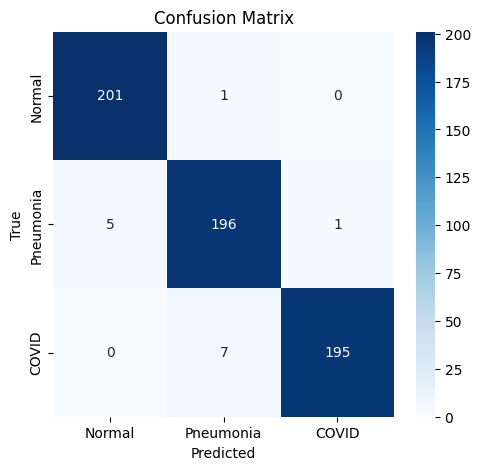

In [ ]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5.5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



# **🖼️ Test Predictions — Truth vs Predicted**
We randomly display several test images along with:
- True label (T)
- Predicted label (P)  
If the prediction is correct, the title is green; if wrong, it's red.


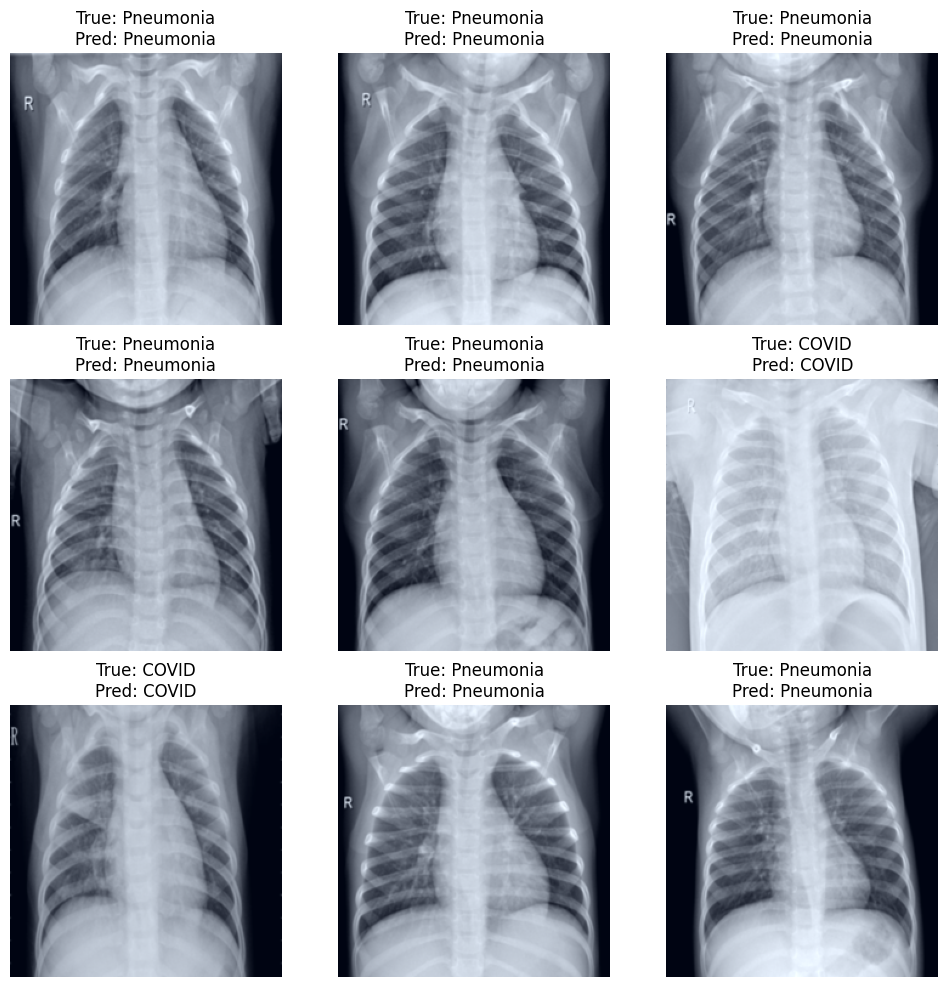

In [ ]:
# Show some sample predictions
fig, axes = plt.subplots(3, 3, figsize=(12,12))
for i, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = efficientnet(images)
    preds = torch.argmax(outputs, dim=1)
    for j in range(min(3, len(images))):
        img = images[j].cpu().permute(1,2,0).numpy()
        img = img * 0.229 + 0.485  # Unnormalize
        axes[i,j].imshow(img)
        axes[i,j].set_title(f"True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}")
        axes[i,j].axis('off')
    if i==2:  # Only show first 3 batches
        break
plt.show()

# **📊 Overall Model Performance**
We display a bar chart showing:
- Accuracy
- Precision
- Recall
- F1-score  
All values are in percentage format for easy interpretation.


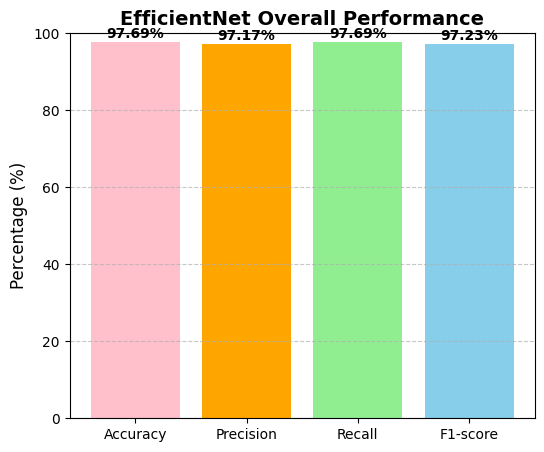

In [ ]:
import matplotlib.pyplot as plt

# Overall metrics from EfficientNet classification report
metrics = {
    "Accuracy": 97.69,
    "Precision": 97.17,  # Macro avg from report
    "Recall": 97.69,     # Macro avg
    "F1-score": 97.23    # Macro avg
}

# Create bar plot
plt.figure(figsize=(6, 5))
bars = plt.bar(metrics.keys(), metrics.values(), color=['pink' ,'orange', 'lightgreen', 'skyblue'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f"{height:.2f}%",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Styling
plt.ylim(0, 100)
plt.ylabel("Percentage (%)", fontsize=12)
plt.title("EfficientNet Overall Performance", fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


# **📈 Confidence Distribution**
We visualize the model's **confidence scores** for:
- Correct predictions
- Incorrect predictions  
This helps understand whether the model is overconfident in wrong predictions.


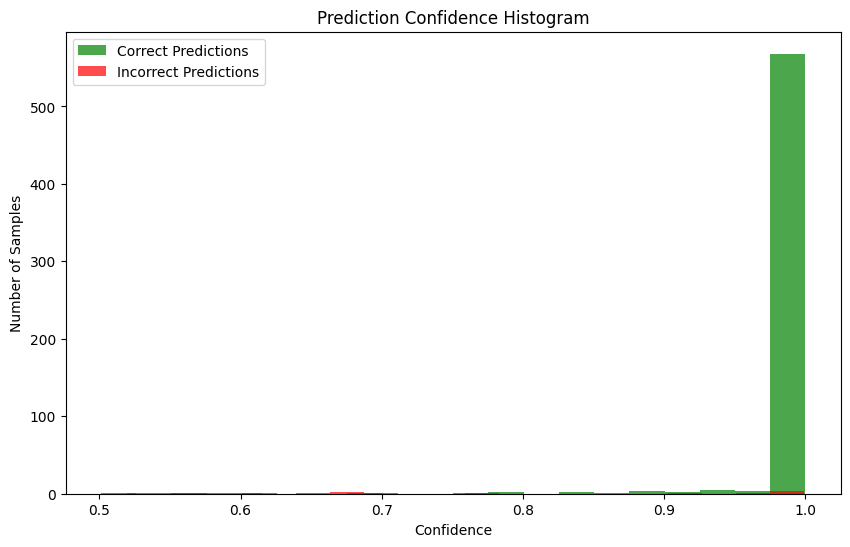

In [ ]:
# ==========================================
# 📊 Confidence Distribution Histogram for EfficientNet
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

efficientnet.eval()

all_probs = []
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet(images)
        probs = F.softmax(outputs, dim=1)  # Get probabilities
        preds = torch.argmax(probs, dim=1)

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Separate correct and incorrect predictions
correct_mask = all_preds == all_labels
incorrect_mask = all_preds != all_labels

# Get max confidence for each sample
correct_conf = all_probs[correct_mask].max(axis=1)
incorrect_conf = all_probs[incorrect_mask].max(axis=1)

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(correct_conf, bins=20, alpha=0.7, label="Correct Predictions", color='green')
plt.hist(incorrect_conf, bins=20, alpha=0.7, label="Incorrect Predictions", color='red')
plt.title("Prediction Confidence Histogram")
plt.xlabel("Confidence")
plt.ylabel("Number of Samples")
plt.legend()
plt.show()


# **🌐 t-SNE Visualization of EfficientNet Features**

Extracts high-dimensional features from EfficientNet’s penultimate layer and reduces them to **2D** using t-SNE to visualize how well the model separates different classes in feature space.



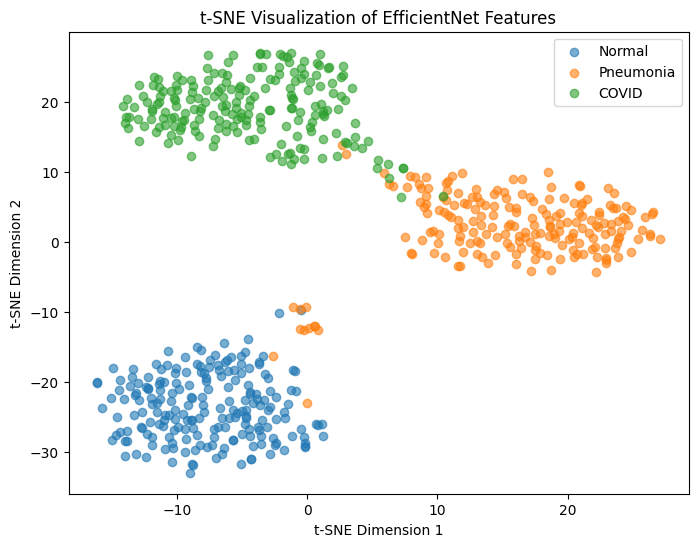

In [ ]:
# ==========================================
# 🌐 t-SNE Visualization of EfficientNet Features
# ==========================================
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

efficientnet.eval()

features_list = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Extract features from EfficientNet's penultimate layer
        feat = efficientnet.features(images)          # Shape: [batch, 1280, 7, 7]
        feat = torch.flatten(feat, start_dim=1)       # Flatten to [batch, 1280*7*7]
        features_list.append(feat.cpu())
        labels_list.extend(labels.cpu().numpy())

# Concatenate all features
features = torch.cat(features_list, dim=0).numpy()
labels = np.array(labels_list)

# t-SNE to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Plot
class_names = ['Normal', 'Pneumonia', 'COVID']
plt.figure(figsize=(8,6))
for i, c in enumerate(class_names):
    idxs = labels == i
    plt.scatter(tsne_results[idxs,0], tsne_results[idxs,1], label=c, alpha=0.6)

plt.legend()
plt.title("t-SNE Visualization of EfficientNet Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


# **🚫 Misclassified Samples**
We display a grid of images that the model misclassified, with:
- True label
- Predicted label (in red)  
This helps identify common failure patterns in the model.


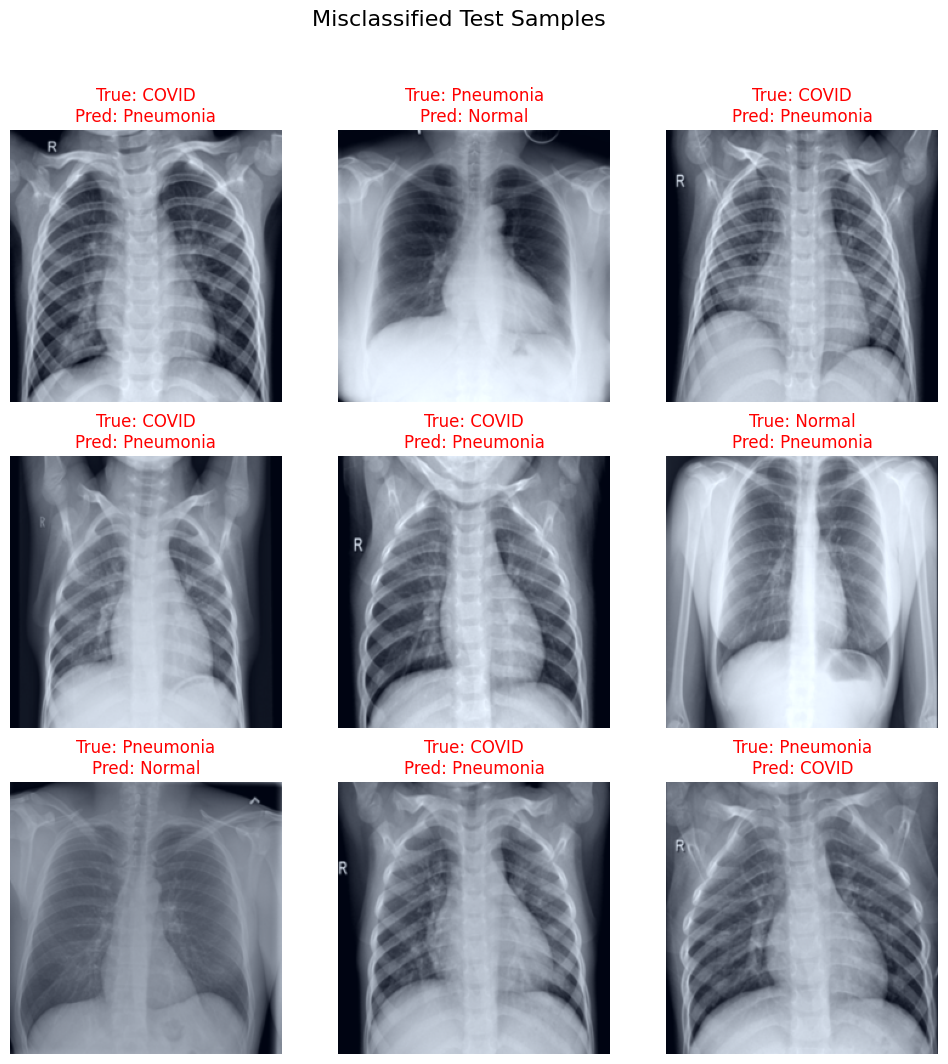

In [ ]:
# ==========================================
# 🚫 Misclassified Samples for EfficientNet
# ==========================================
import matplotlib.pyplot as plt
import numpy as np

efficientnet.eval()
mis_images, mis_true, mis_pred = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet(images)
        preds = torch.argmax(outputs, dim=1)

        for i in range(len(labels)):
            if preds[i] != labels[i]:
                mis_images.append(images[i].cpu())
                mis_true.append(labels[i].cpu())
                mis_pred.append(preds[i].cpu())

# Plot first 9 misclassified images
fig, axes = plt.subplots(3, 3, figsize=(12,12))
class_names = ['Normal', 'Pneumonia', 'COVID']

for i in range(min(len(mis_images), 9)):
    img = mis_images[i].permute(1,2,0).numpy()  # CHW -> HWC
    img = img * 0.229 + 0.485  # Unnormalize
    axes[i//3, i%3].imshow(img)
    axes[i//3, i%3].set_title(f"True: {class_names[mis_true[i]]}\nPred: {class_names[mis_pred[i]]}", color='red')
    axes[i//3, i%3].axis('off')

plt.suptitle("Misclassified Test Samples", fontsize=16)
plt.show()
